# Importing Libraries

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datastyle import styled
from matplotlib import style    
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Data Loading and Inspection

In [3]:
covid = pd.read_csv("WHO-COVID-19-global-daily-data.csv")

In [4]:
d = covid.duplicated().sum()
print(f"Number of duplicate rows: {d}")

Number of duplicate rows: 0


In [5]:
styled(covid.head())

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-04,AI,Anguilla,AMR,nan,0,nan,0
1,2020-01-04,AZ,Azerbaijan,EUR,nan,0,nan,0
2,2020-01-04,BD,Bangladesh,SEAR,0.000000,0,0.000000,0
3,2020-01-04,BB,Barbados,AMR,nan,0,nan,0
4,2020-01-04,BR,Brazil,AMR,nan,0,nan,0


In [6]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489360 entries, 0 to 489359
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date_reported      489360 non-null  object 
 1   Country_code       487321 non-null  object 
 2   Country            489360 non-null  object 
 3   WHO_region         489360 non-null  object 
 4   New_cases          210338 non-null  float64
 5   Cumulative_cases   489360 non-null  int64  
 6   New_deaths         153975 non-null  float64
 7   Cumulative_deaths  489360 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 29.9+ MB


In [7]:
styled(covid.describe().T)

,count,mean,std,min,25%,50%,75%,max
New_cases,210338.000000,3701.063132,48564.626993,-65079.000000,3.000000,61.000000,677.000000,6966046.000000
Cumulative_cases,489360.000000,2044598.341383,8522920.662339,0.000000,6602.000000,59502.000000,660937.000000,103436829.000000
New_deaths,153975.000000,46.109537,242.358188,-3520.000000,0.000000,2.000000,15.000000,44047.000000
Cumulative_deaths,489360.000000,21675.557571,86811.196156,0.000000,40.000000,690.000000,7942.000000,1226130.000000


In [8]:
styled(covid.describe(include='O'))

,Date_reported,Country_code,Country,WHO_region
count,489360,487321,489360,489360
unique,2039,239,240,7
top,2020-01-04,AI,Anguilla,EUR
freq,240,2039,2039,126418


In [9]:
styled(covid.isnull().mean()*100)

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,0.000000,0.416667,0.000000,0.000000,57.017737,0.000000,68.535434,0.000000


# Data Cleaning

In [10]:
# Convert 'Date_reported' to datetime
covid['Date_reported'] = pd.to_datetime(covid['Date_reported'])

In [11]:
# Handle missing values in daily new cases/deaths
# NaN means "no data reported" (in reality = 0 cases/deaths) 

covid['New_cases'] = covid['New_cases'].fillna(0)
covid['New_deaths'] = covid['New_deaths'].fillna(0)

In [12]:
# Replace negative daily values with 0
# Negative values appear when countries correct earlier reporting mistakes

covid['New_cases'] = covid['New_cases'].clip(lower=0)
covid['New_deaths'] = covid['New_deaths'].clip(lower=0)


In [13]:
# Checking the countries with missing Country_code
missing_codes = covid[covid['Country_code'].isnull()]['Country'].unique()
missing_codes

array(['Namibia'], dtype=object)

In [14]:
# namibia is the only country with missing Country_code and its code is NA
covid['Country_code'] = covid['Country_code'].fillna('NA')

In [15]:
# count the number of countries with missing codes
covid['Country_code'].isnull().sum()

np.int64(0)

In [16]:
covid['Year'] = covid['Date_reported'].dt.year
covid['Month'] = covid['Date_reported'].dt.month
covid['Day'] = covid['Date_reported'].dt.day
styled(covid.head())

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Year,Month,Day
0,2020-01-04 00:00:00,AI,Anguilla,AMR,0.000000,0,0.000000,0,2020,1,4
1,2020-01-04 00:00:00,AZ,Azerbaijan,EUR,0.000000,0,0.000000,0,2020,1,4
2,2020-01-04 00:00:00,BD,Bangladesh,SEAR,0.000000,0,0.000000,0,2020,1,4
3,2020-01-04 00:00:00,BB,Barbados,AMR,0.000000,0,0.000000,0,2020,1,4
4,2020-01-04 00:00:00,BR,Brazil,AMR,0.000000,0,0.000000,0,2020,1,4


In [17]:
# Active days: at least 1 new case OR 1 new death
active_days = covid[(covid['New_cases'] != 0) | (covid['New_deaths'] != 0)].copy()

# No cases/deaths days: both new cases AND new deaths = 0
no_cases_days = covid[(covid['New_cases'] == 0) & (covid['New_deaths'] == 0)].copy()

print("Active days shape:", active_days.shape)
print("No-cases days shape:", no_cases_days.shape)

# Quick check: they should together equal the full dataset
print("Original shape:", covid.shape)
print("Check split:", active_days.shape[0] + no_cases_days.shape[0] == covid.shape[0])


Active days shape: (172213, 11)
No-cases days shape: (317147, 11)
Original shape: (489360, 11)
Check split: True


# Feature Engineering

In [18]:
# Rolling averages (7-day smoothing)
covid['Cases_7d_avg'] = (
    covid.groupby('Country')['New_cases']
         .transform(lambda x: x.rolling(7, min_periods=1).mean())
)

covid['Deaths_7d_avg'] = (
    covid.groupby('Country')['New_deaths']
         .transform(lambda x: x.rolling(7, min_periods=1).mean())
)


In [19]:
# Case Fatality Ratio
covid['CFR'] = covid['Cumulative_deaths'] / covid['Cumulative_cases']

In [20]:
# Growth rate / daily ratio
covid['Growth_ratio'] = covid['New_cases'] / covid['Cases_7d_avg']

In [21]:
# Days since first case
first_case_date = covid[covid['Cumulative_cases'] > 0].groupby('Country')['Date_reported'].transform('min')
covid['Days_since_first_case'] = (covid['Date_reported'] - first_case_date).dt.days


In [22]:
# Month start date
covid['Month_start'] = covid['Date_reported'].dt.to_period('M').dt.to_timestamp()


# Univarient

********************** Univariate Analysis **********************


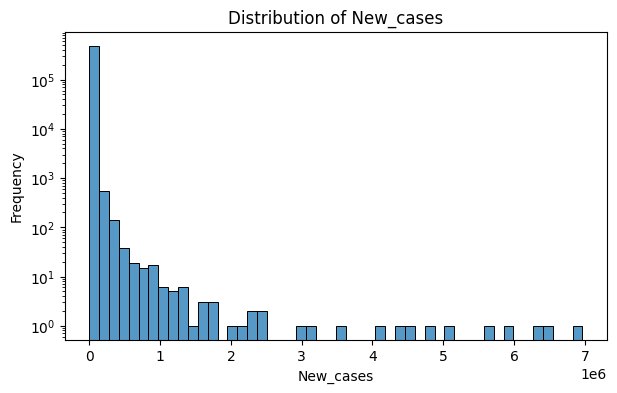

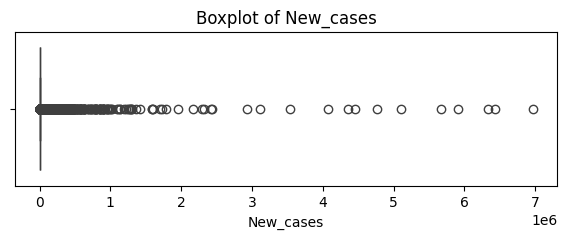

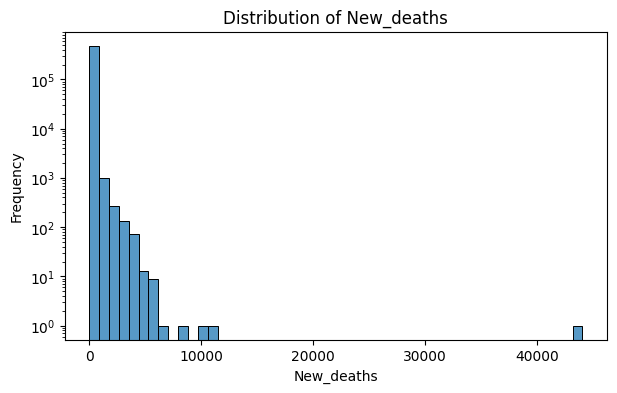

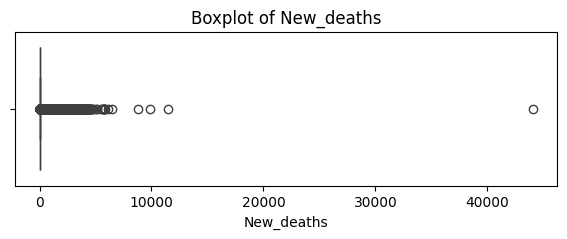

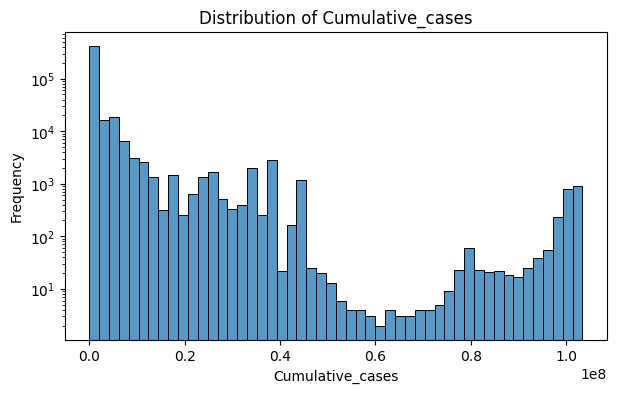

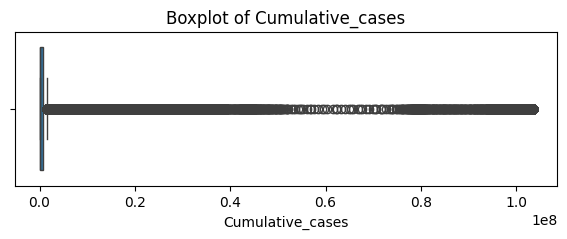

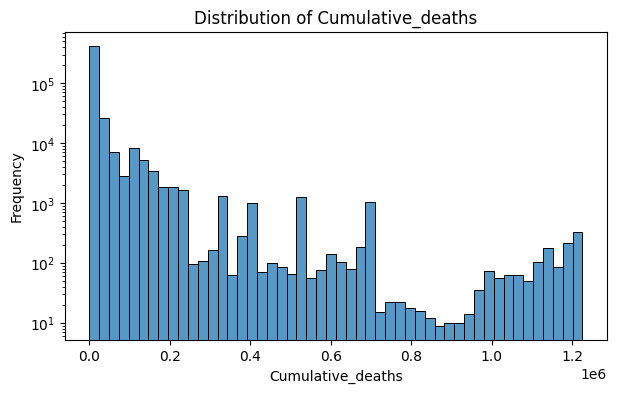

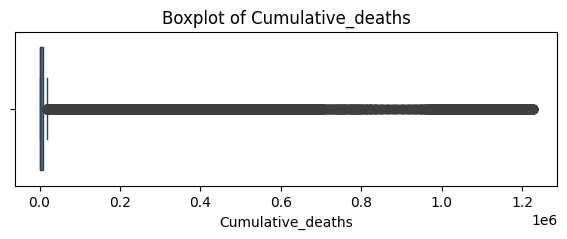


Value counts for WHO_region:


,WHO_region,Count
0,EUR,126418
1,AMR,110106
2,AFR,101950
3,WPR,73404
4,EMR,44858
5,SEAR,20390
6,OTHER,12234


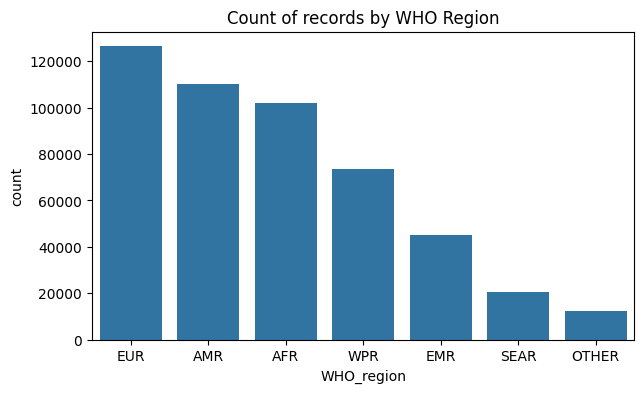


Top 10 Countries by Total Cases:


,Country,Cumulative_cases
489156,United States of America,103436829
489303,China,99381761
489135,India,45055912
489287,France,39042805
489255,Germany,38437874
489124,Brazil,37764182
489300,Republic of Korea,34571873
489172,Japan,33803572
489232,Italy,26968605
489203,United Kingdom of Great Britain and Northern Ireland,25062962



Top 10 Countries by Total Deaths:


,Country,Cumulative_deaths
489156,United States of America,1226130
489124,Brazil,703023
489135,India,533834
489180,Russian Federation,404290
489357,Mexico,335007
489203,United Kingdom of Great Britain and Northern Ireland,232112
489179,Peru,221060
489232,Italy,198523
489255,Germany,174979
489287,France,168162


In [25]:
def univariate_analysis(df):
    print("********************** Univariate Analysis **********************")

    # 1. Histograms + Boxplots for numeric columns
    num_cols = ["New_cases", "New_deaths", "Cumulative_cases", "Cumulative_deaths"]
    for col in num_cols:
        if col in df.columns:
            plt.figure(figsize=(7,4))
            sns.histplot(df[col], bins=50, kde=False)
            plt.title(f"Distribution of {col}")
            plt.xlabel(col)
            plt.ylabel("Frequency")
            plt.yscale("log")   # log scale helps since COVID data is skewed
            plt.show()

            # Boxplot
            plt.figure(figsize=(7,2))
            sns.boxplot(x=df[col])
            plt.title(f"Boxplot of {col}")
            plt.show()

    # 2. Value counts for categorical columns
    if "WHO_region" in df.columns:
        vc = df["WHO_region"].value_counts().reset_index()
        vc.columns = ["WHO_region", "Count"]
        print("\nValue counts for WHO_region:")
        display(styled(vc, caption="Records per WHO Region"))

        plt.figure(figsize=(7,4))
        sns.countplot(x="WHO_region", data=df, order=df["WHO_region"].value_counts().index)
        plt.title("Count of records by WHO Region")
        plt.show()

    # 3. Latest snapshot per country
    if "Cumulative_cases" in df.columns and "Cumulative_deaths" in df.columns:
        latest = df.sort_values("Date_reported").groupby("Country").tail(1)

        top_cases = latest.nlargest(10, "Cumulative_cases")[["Country","Cumulative_cases"]]
        top_deaths = latest.nlargest(10, "Cumulative_deaths")[["Country","Cumulative_deaths"]]

        print("\nTop 10 Countries by Total Cases:")
        display(styled(top_cases, caption="Top 10 Countries by Cases"))

        print("\nTop 10 Countries by Total Deaths:")
        display(styled(top_deaths, caption="Top 10 Countries by Deaths"))

univariate_analysis(covid)

# Bivarient

********************** Bivariate Analysis **********************

Correlation Table:


,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Year,Month,Day,Cases_7d_avg,Deaths_7d_avg,CFR,Growth_ratio,Days_since_first_case
New_cases,1.000000,0.110000,0.270000,0.090000,-0.020000,-0.000000,0.000000,0.870000,0.250000,-0.000000,0.050000,-0.020000
Cumulative_cases,0.110000,1.000000,0.150000,0.790000,0.140000,0.000000,0.000000,0.140000,0.200000,-0.000000,-0.000000,0.160000
New_deaths,0.270000,0.150000,1.000000,0.230000,-0.080000,-0.000000,-0.000000,0.250000,0.760000,0.020000,0.060000,-0.090000
Cumulative_deaths,0.090000,0.790000,0.230000,1.000000,0.100000,0.010000,0.000000,0.110000,0.300000,-0.000000,-0.000000,0.120000
Year,-0.020000,0.140000,-0.080000,0.100000,1.000000,-0.130000,-0.010000,-0.020000,-0.110000,-0.020000,-0.010000,0.950000
Month,-0.000000,0.000000,-0.000000,0.010000,-0.130000,1.000000,0.010000,-0.000000,-0.000000,-0.010000,-0.000000,-0.030000
Day,0.000000,0.000000,-0.000000,0.000000,-0.010000,0.010000,1.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000
Cases_7d_avg,0.870000,0.140000,0.250000,0.110000,-0.020000,-0.000000,0.000000,1.000000,0.300000,-0.000000,-0.000000,-0.020000
Deaths_7d_avg,0.250000,0.200000,0.760000,0.300000,-0.110000,-0.000000,-0.000000,0.300000,1.000000,0.020000,-0.000000,-0.120000
CFR,-0.000000,-0.000000,0.020000,-0.000000,-0.020000,-0.010000,-0.000000,-0.000000,0.020000,1.000000,-0.000000,-0.020000


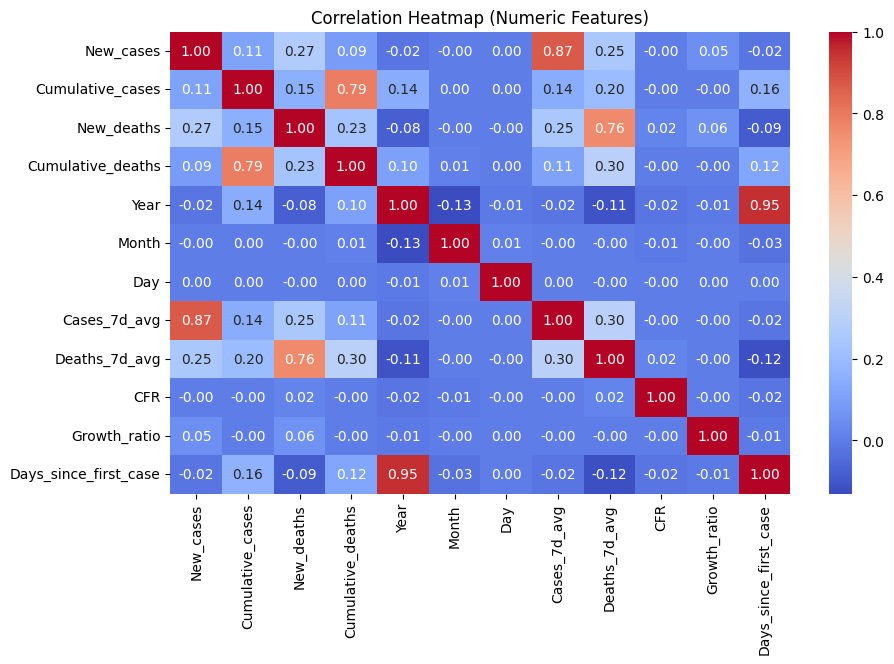

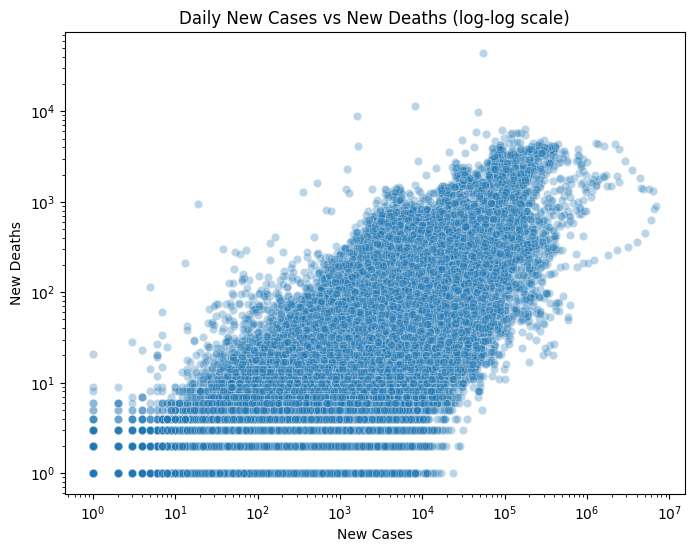

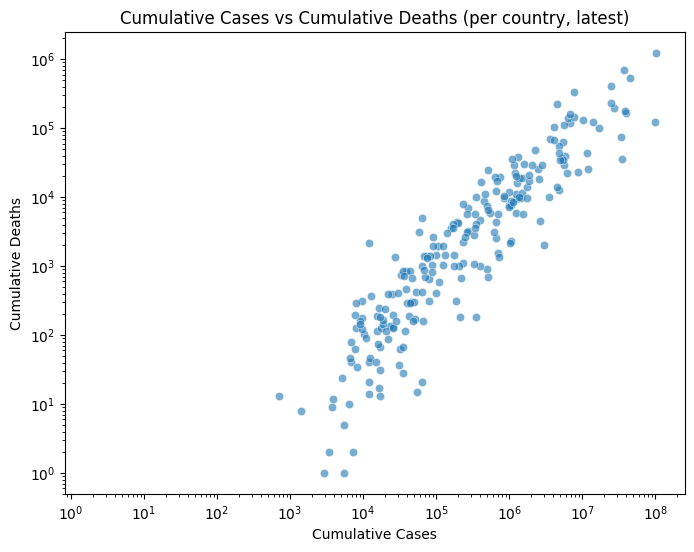


Top 10 Countries by Deaths-to-Cases ratio (min 1000 cases):


,Country,Cumulative_cases,Cumulative_deaths,Deaths_to_Cases
489340,Yemen,11945,2159,0.180745
489336,Sudan,63993,5046,0.078852
489150,Syrian Arab Republic,57423,3163,0.055082
489213,Somalia,27334,1361,0.049791
489179,Peru,4532699,221060,0.048770
489189,Egypt,516023,24830,0.048118
489357,Mexico,7628380,335007,0.043916
489185,Bosnia and Herzegovina,404287,16406,0.040580
489316,Liberia,7932,294,0.037065
489218,Afghanistan,235214,7998,0.034003


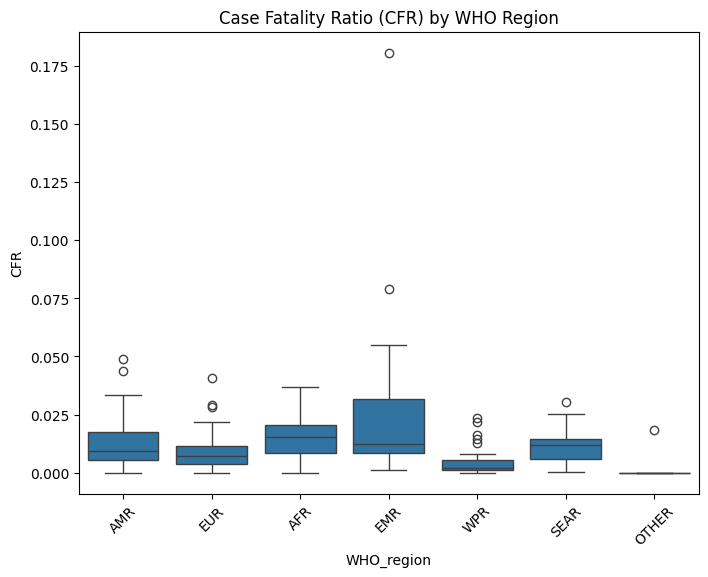

In [27]:
def bivariate_analysis(df):
    print("********************** Bivariate Analysis **********************")

    # 1. Correlation Heatmap + Correlation Table
    num_cols = df.select_dtypes(include='number')
    corr = num_cols.corr().round(2)

    print("\nCorrelation Table:")
    display(styled(corr, caption="Correlation Matrix (Numeric Features)"))

    plt.figure(figsize=(10,6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.show()

    # 2. Scatterplot: New cases vs New deaths (daily)
    if "New_cases" in df.columns and "New_deaths" in df.columns:
        plt.figure(figsize=(8,6))
        sns.scatterplot(x="New_cases", y="New_deaths", data=df, alpha=0.3)
        plt.xscale("log"); plt.yscale("log")
        plt.title("Daily New Cases vs New Deaths (log-log scale)")
        plt.xlabel("New Cases")
        plt.ylabel("New Deaths")
        plt.show()

    # 3. Latest snapshot: cumulative cases vs cumulative deaths
    if "Cumulative_cases" in df.columns and "Cumulative_deaths" in df.columns:
        latest = df.sort_values("Date_reported").groupby("Country").tail(1)

        plt.figure(figsize=(8,6))
        sns.scatterplot(x="Cumulative_cases", y="Cumulative_deaths", data=latest, alpha=0.6)
        plt.xscale("log"); plt.yscale("log")
        plt.title("Cumulative Cases vs Cumulative Deaths (per country, latest)")
        plt.xlabel("Cumulative Cases")
        plt.ylabel("Cumulative Deaths")
        plt.show()

        # Show Top 10 by correlation ratio (deaths/cases)
        latest["Deaths_to_Cases"] = latest["Cumulative_deaths"] / latest["Cumulative_cases"]
        top_ratio = latest[latest["Cumulative_cases"] > 1000] \
                        .nlargest(10, "Deaths_to_Cases")[["Country","Cumulative_cases","Cumulative_deaths","Deaths_to_Cases"]]

        print("\nTop 10 Countries by Deaths-to-Cases ratio (min 1000 cases):")
        display(styled(top_ratio, caption="Top 10 CFR-like Ratios"))

    # 4. CFR distribution by WHO region (if available)
    if "WHO_region" in df.columns and "CFR" in df.columns:
        latest = df.sort_values("Date_reported").groupby("Country").tail(1)
        plt.figure(figsize=(8,6))
        sns.boxplot(x="WHO_region", y="CFR", data=latest)
        plt.title("Case Fatality Ratio (CFR) by WHO Region")
        plt.xticks(rotation=45)
        plt.show()

bivariate_analysis(covid)

# Multvarient

********************** Multivariate Analysis **********************


,WHO_region,Cumulative_cases,Cumulative_deaths
0,AFR,9588854,175532
1,AMR,193602165,3060197
2,EMR,23417911,351975
3,EUR,281322281,2280998
4,OTHER,764,13
5,SEAR,55101182,647256
6,WPR,215441060,583745


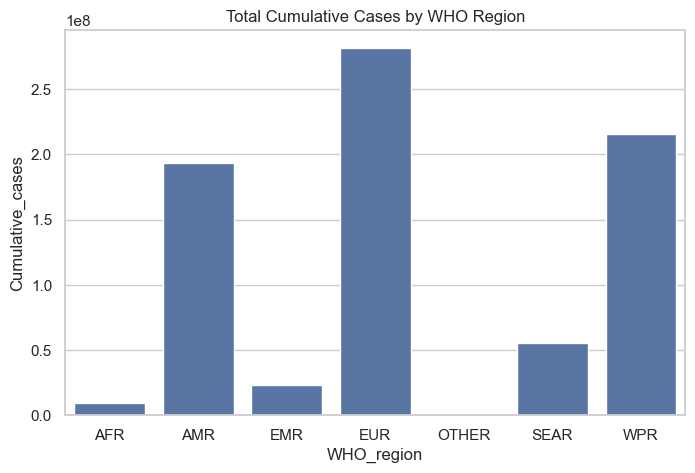

WHO_region,AFR,AMR,EMR,EUR,OTHER,SEAR,WPR
YearMonth,,,,,,,
2024-09-01 00:00:00,653.000000,4686.000000,0.000000,438215.000000,0.000000,2371.000000,10100.000000
2024-10-01 00:00:00,524.000000,7140.000000,0.000000,252983.000000,0.000000,2128.000000,8167.000000
2024-11-01 00:00:00,484.000000,5821.000000,0.000000,178727.000000,0.000000,2913.000000,10480.000000
2024-12-01 00:00:00,1421.000000,20612.000000,0.000000,200057.000000,0.000000,2303.000000,14138.000000
2025-01-01 00:00:00,1287.000000,80989.000000,0.000000,74834.000000,0.000000,61.000000,4208.000000
2025-02-01 00:00:00,320.000000,89418.000000,0.000000,49857.000000,0.000000,5589.000000,21.000000
2025-03-01 00:00:00,248.000000,33328.000000,0.000000,32353.000000,0.000000,54.000000,8.000000
2025-04-01 00:00:00,177.000000,16874.000000,0.000000,14972.000000,0.000000,131.000000,15.000000
2025-05-01 00:00:00,243.000000,15122.000000,0.000000,16178.000000,0.000000,270122.000000,30.000000


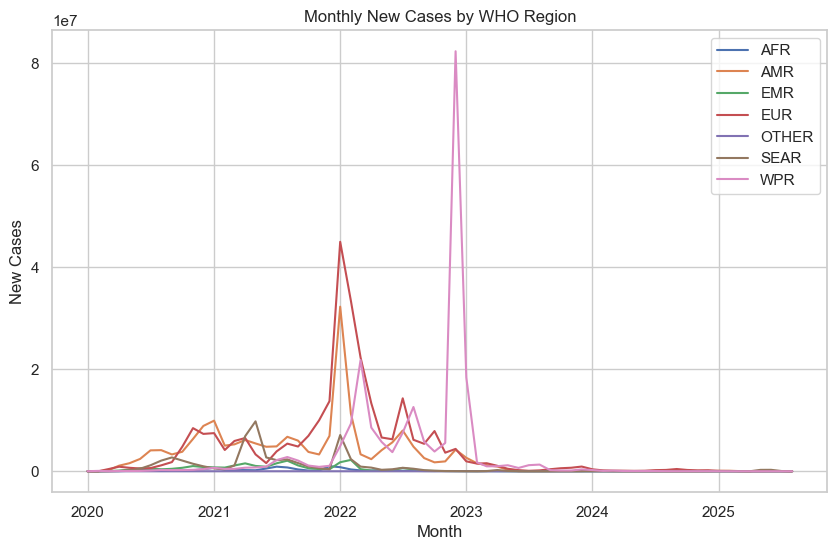

,New_cases,New_deaths,Cumulative_cases,Cumulative_deaths
New_cases,1.000000,0.270000,0.110000,0.090000
New_deaths,0.270000,1.000000,0.150000,0.230000
Cumulative_cases,0.110000,0.150000,1.000000,0.790000
Cumulative_deaths,0.090000,0.230000,0.790000,1.000000


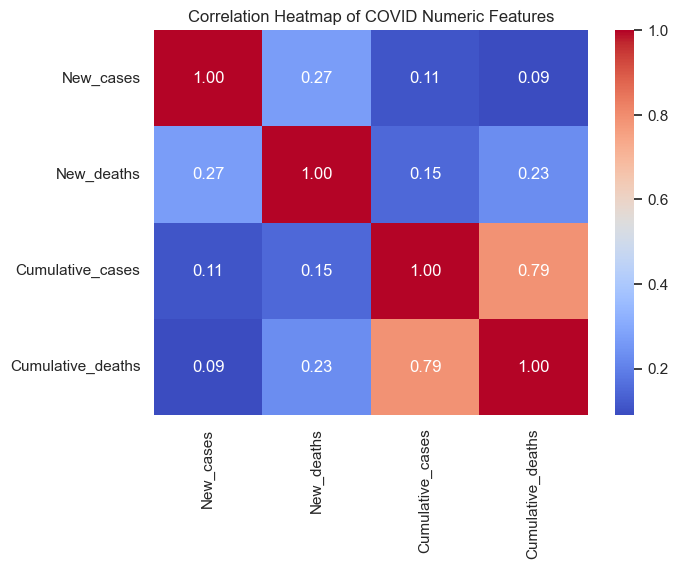

In [32]:
def multivariate_analysis(df):
    print("********************** Multivariate Analysis **********************")

    # 1. Groupby example: total cases & deaths by WHO region (latest snapshot)
    if "WHO_region" in df.columns:
        latest = df.sort_values("Date_reported").groupby("Country").tail(1)
        region_summary = latest.groupby("WHO_region")[["Cumulative_cases","Cumulative_deaths"]].sum().reset_index()
        display(styled(region_summary, caption="Total Cases & Deaths by WHO Region"))

        plt.figure(figsize=(8,5))
        sns.barplot(x="WHO_region", y="Cumulative_cases", data=region_summary)
        plt.title("Total Cumulative Cases by WHO Region")
        plt.show()

    # 2. Pivot example: monthly cases per region
    if "WHO_region" in df.columns and "Date_reported" in df.columns:
        df['YearMonth'] = df['Date_reported'].dt.to_period('M').dt.to_timestamp()
        monthly = df.groupby(["WHO_region","YearMonth"])["New_cases"].sum().reset_index()
        pivot_table = monthly.pivot(index="YearMonth", columns="WHO_region", values="New_cases").fillna(0)

        display(styled(pivot_table.tail(12), caption="Monthly New Cases by WHO Region (last 12 months)"))

        plt.figure(figsize=(10,6))
        for col in pivot_table.columns:
            plt.plot(pivot_table.index, pivot_table[col], label=col)
        plt.title("Monthly New Cases by WHO Region")
        plt.xlabel("Month")
        plt.ylabel("New Cases")
        plt.legend()
        plt.show()

    # 3. Correlation heatmap of key numeric features
    num_cols = ["New_cases","New_deaths","Cumulative_cases","Cumulative_deaths"]
    num_cols = [c for c in num_cols if c in df.columns]

    corr = df[num_cols].corr().round(2)
    display(styled(corr, caption="Correlation Matrix"))

    plt.figure(figsize=(7,5))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap of COVID Numeric Features")
    plt.show()

multivariate_analysis(covid)


# Conclusion and Insights

- Dataset was complete across countries and dates; negative values were corrected using cumulative totals.

- Daily new cases and deaths were highly right-skewed (many low days, few extreme spikes).

- A small number of countries dominated global totals (e.g., USA, India, Brazil).

- Most countries had CFR < 5%, but some outliers showed much higher values due to testing/reporting gaps.

- Strong positive correlation between new cases and new deaths (with lag).

- Cumulative cases and deaths were strongly correlated at the country level.

- Europe and the Americas carried the largest share of global cases and deaths.

- Regional and monthly pivots revealed distinct waves of infection.

- Multivariate view showed outbreak scale (totals) and severity (CFR) as the main factors differentiating countries.

- Overall: COVID-19 impact was unevenly distributed, concentrated in certain regions, with large variation in fatality ratios.